In [1]:
# fix for memory issues
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from hw2.transforms import corrupt_mnist_copy

(x_train, _), (x_test, _) = mnist.load_data()

x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

# Scale to [0, 1]
x_train = x_train.astype(K.floatx()) / 255.
x_train_corrupted = x_train_corrupted.astype(K.floatx()) / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_train_corrupted = np.reshape(x_train_corrupted, (len(x_train_corrupted), 28, 28, 1))

x_test = x_test.astype(K.floatx()) / 255.
x_test_corrupted = x_test_corrupted.astype(K.floatx()) / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_test_corrupted = np.reshape(x_test_corrupted, (len(x_test_corrupted), 28, 28, 1))

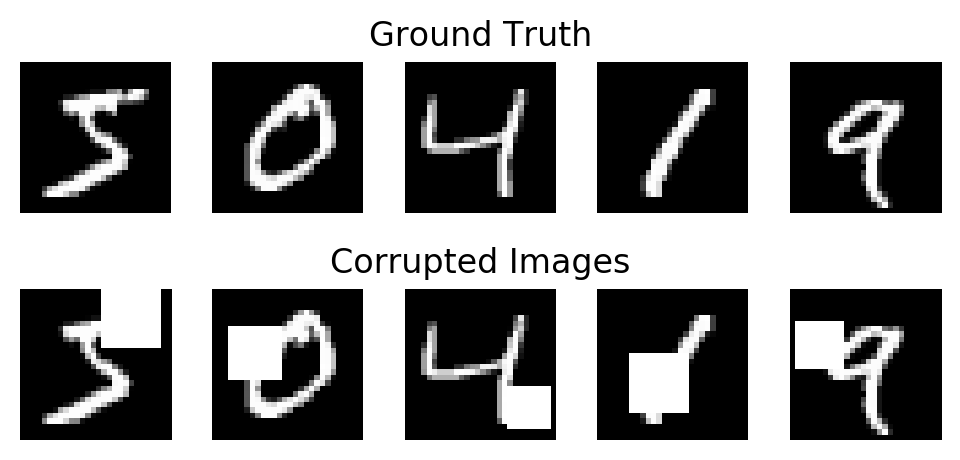

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200
plt.subplots_adjust(wspace = 0.2,hspace=.5)

for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.imshow(np.squeeze(x_train[i]),cmap='gray')
    if (i==2):
        plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(3,5,i+6)
    plt.imshow(np.squeeze(x_train_corrupted[i]),cmap='gray')
    if (i==2):
        plt.title('Corrupted Images')
    plt.axis('off')

In [4]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D

input_img = Input(shape=(28,28,1))

x = Conv2D(32, [3,3], 
           strides=(1, 1),
           activation='relu',
           padding='same',
           data_format='channels_last',
           use_bias=True,
           kernel_initializer='lecun_normal',
           bias_initializer='lecun_normal',
           kernel_regularizer=None,
           bias_regularizer=None,
           activity_regularizer=None,
           kernel_constraint=None,
           bias_constraint=None
          )(input_img)

x = MaxPooling2D(pool_size=(2, 2), 
                 strides=None, 
                 padding='same', 
                 data_format='channels_last')(x)

x = Conv2D(16, [3,3], 
           strides=(1, 1),
           activation='relu', 
           padding='same',
           data_format='channels_last',
           use_bias=True,
           kernel_initializer='lecun_normal',
           bias_initializer='lecun_normal',
           kernel_regularizer=None,
           bias_regularizer=None,
           activity_regularizer=None,
           kernel_constraint=None,
           bias_constraint=None
          )(x)

x = MaxPooling2D(pool_size=(2, 2), 
                 strides=None, 
                 padding='same', 
                 data_format='channels_last')(x)

encoded = Conv2D(16, [3,3], 
           strides=(1, 1), 
           padding='same',
           activation='relu',
           data_format='channels_last',
           use_bias=True,
           kernel_initializer='lecun_normal',
           bias_initializer='lecun_normal',
           kernel_regularizer=None,
           bias_regularizer=None,
           activity_regularizer=None,
           kernel_constraint=None,
           bias_constraint=None
          )(x)

x = UpSampling2D(size=(2, 2), 
                 data_format='channels_last', 
                 interpolation='nearest'
                )(encoded)

x = Conv2D(32, [3,3], 
           strides=(1, 1), 
           padding='same',
           activation='relu',
           data_format='channels_last',
           use_bias=True,
           kernel_initializer='lecun_normal',
           bias_initializer='lecun_normal',
           kernel_regularizer=None,
           bias_regularizer=None,
           activity_regularizer=None,
           kernel_constraint=None,
           bias_constraint=None
          )(x)

x = UpSampling2D(size=(2, 2), 
                 data_format='channels_last', 
                 interpolation='nearest'
                )(x)

decoder = Conv2D(1, [3,3], 
           strides=(1, 1), 
           padding='same',
           data_format='channels_last',
           activation='sigmoid',
           use_bias=True,
           kernel_initializer='lecun_normal',
           bias_initializer='lecun_normal',
           kernel_regularizer=None,
           bias_regularizer=None,
           activity_regularizer=None,
           kernel_constraint=None,
           bias_constraint=None
          )(x)

autoencoder = Model(input_img,decoder)

autoencoder.summary()

adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

tensor_board = TensorBoard('logs\\run008-adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0     

In [5]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

batch_size = 64
epochs = 250

callbacks = [tensor_board]

history = autoencoder.fit(x_train_corrupted, x_train, batch_size = batch_size, epochs=epochs, verbose=1,
         validation_data=(x_test_corrupted, x_test), callbacks=callbacks)

score = autoencoder.evaluate(x_train_corrupted, x_train,
                       batch_size=batch_size,
                       verbose=1)

#print('Training took {} seconds'.format(time.time()-start_time))

print_score = f"{score[1]*100:.2f}%"
%notify -m "Training has finished. Validation accuracy is {print_score}."

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 10s 164us/sample - loss: 0.1787 - binary_accuracy: 0.7922 - val_loss: 0.1254 - val_binary_accuracy: 0.8084
Epoch 2/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1216 - binary_accuracy: 0.8092 - val_loss: 0.1166 - val_binary_accuracy: 0.8085
Epoch 3/250
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1159 - binary_accuracy: 0.8100 - val_loss: 0.1132 - val_binary_accuracy: 0.8098
Epoch 4/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1130 - binary_accuracy: 0.8103 - val_loss: 0.1113 - val_binary_accuracy: 0.8083
Epoch 5/250
60000/60000 [==============================] - 7s 122us/sample - loss: 0.1110 - binary_accuracy: 0.8105 - val_loss: 0.1087 - val_binary_accuracy: 0.8095
Epoch 6/250
60000/60000 [==============================] - 8s 129us/sample - loss: 0.1095 - binary_accuracy: 0.8107 - val_lo

60000/60000 [==============================] - 7s 113us/sample - loss: 0.0990 - binary_accuracy: 0.8117 - val_loss: 0.0982 - val_binary_accuracy: 0.8103
Epoch 51/250
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0990 - binary_accuracy: 0.8117 - val_loss: 0.0985 - val_binary_accuracy: 0.8099
Epoch 52/250
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0990 - binary_accuracy: 0.8117 - val_loss: 0.0997 - val_binary_accuracy: 0.8118
Epoch 53/250
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0990 - binary_accuracy: 0.8117 - val_loss: 0.0980 - val_binary_accuracy: 0.8112
Epoch 54/250
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0988 - binary_accuracy: 0.8118 - val_loss: 0.0981 - val_binary_accuracy: 0.8113
Epoch 55/250
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0988 - binary_accuracy: 0.8118 - val_loss: 0.0981 - val_binary_accuracy: 0.8104
Epoch 56/250
6000

60000/60000 [==============================] - 6s 98us/sample - loss: 0.0974 - binary_accuracy: 0.8119 - val_loss: 0.0965 - val_binary_accuracy: 0.8110
Epoch 100/250
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0974 - binary_accuracy: 0.8119 - val_loss: 0.0967 - val_binary_accuracy: 0.8118
Epoch 101/250
60000/60000 [==============================] - 6s 107us/sample - loss: 0.0974 - binary_accuracy: 0.8119 - val_loss: 0.0968 - val_binary_accuracy: 0.8116
Epoch 102/250
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0973 - binary_accuracy: 0.8119 - val_loss: 0.0965 - val_binary_accuracy: 0.8111
Epoch 103/250
60000/60000 [==============================] - 6s 98us/sample - loss: 0.0974 - binary_accuracy: 0.8119 - val_loss: 0.0972 - val_binary_accuracy: 0.8098
Epoch 104/250
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0973 - binary_accuracy: 0.8119 - val_loss: 0.0972 - val_binary_accuracy: 0.8120
Epoch 105/250
60

60000/60000 [==============================] - 4s 64us/sample - loss: 0.0967 - binary_accuracy: 0.8120 - val_loss: 0.0958 - val_binary_accuracy: 0.8108
Epoch 149/250
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0966 - binary_accuracy: 0.8120 - val_loss: 0.0959 - val_binary_accuracy: 0.8105
Epoch 150/250
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0965 - binary_accuracy: 0.8120 - val_loss: 0.0962 - val_binary_accuracy: 0.8114
Epoch 151/250
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0965 - binary_accuracy: 0.8120 - val_loss: 0.0964 - val_binary_accuracy: 0.8096
Epoch 152/250
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0966 - binary_accuracy: 0.8120 - val_loss: 0.0972 - val_binary_accuracy: 0.8091
Epoch 153/250
60000/60000 [==============================] - 5s 77us/sample - loss: 0.0965 - binary_accuracy: 0.8120 - val_loss: 0.0958 - val_binary_accuracy: 0.8111
Epoch 154/250
6000

60000/60000 [==============================] - 4s 64us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0955 - val_binary_accuracy: 0.8102
Epoch 198/250
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0956 - val_binary_accuracy: 0.8102
Epoch 199/250
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0953 - val_binary_accuracy: 0.8109
Epoch 200/250
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0953 - val_binary_accuracy: 0.8112
Epoch 201/250
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0959 - val_binary_accuracy: 0.8111
Epoch 202/250
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0960 - binary_accuracy: 0.8120 - val_loss: 0.0956 - val_binary_accuracy: 0.8109
Epoch 203/250
6000

60000/60000 [==============================] - 4s 69us/sample - loss: 0.0957 - binary_accuracy: 0.8121 - val_loss: 0.0958 - val_binary_accuracy: 0.8096
Epoch 247/250
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0957 - binary_accuracy: 0.8120 - val_loss: 0.0951 - val_binary_accuracy: 0.8112
Epoch 248/250
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0956 - binary_accuracy: 0.8121 - val_loss: 0.0958 - val_binary_accuracy: 0.8100
Epoch 249/250
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0957 - binary_accuracy: 0.8120 - val_loss: 0.0955 - val_binary_accuracy: 0.8104
Epoch 250/250
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0955 - binary_accuracy: 0.8124


<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Dump training history
filehandler = open("train_history","wb")
pickle.dump(history.history,filehandler)
filehandler.close()

5/5 [==============================] - 0s 3ms/sample


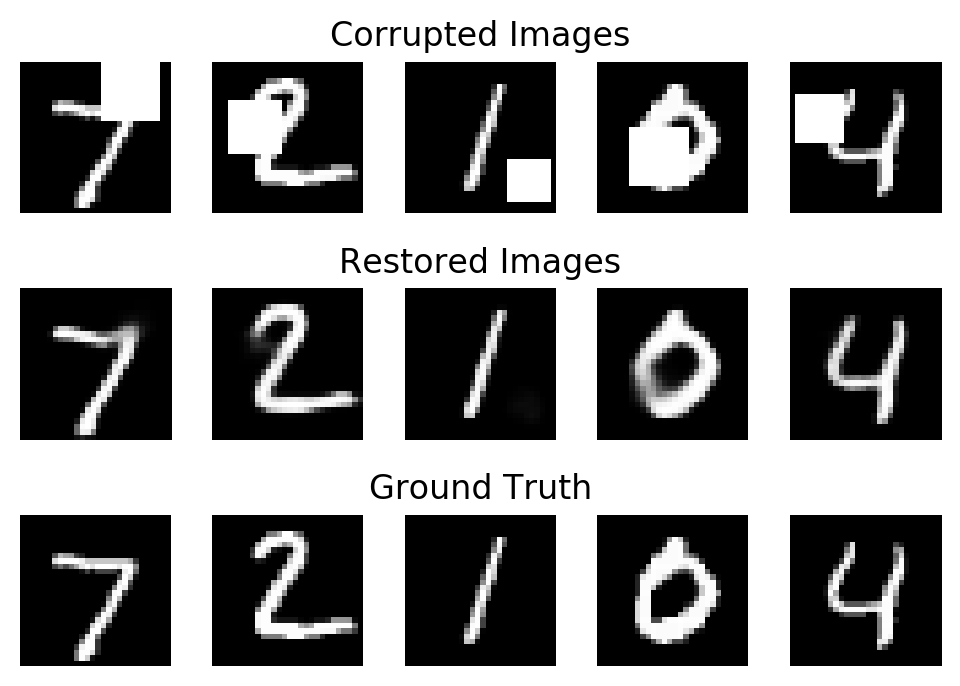

In [8]:
import matplotlib.pyplot as plt

# autoencoder.save('domingo_cnn_ae.h5') 

output = autoencoder.predict(x_test_corrupted[0:5], verbose=1)

plt.rcParams['figure.dpi'] = 200
plt.subplots_adjust(wspace = 0.2,hspace=0.5)
for i in range(0,5):
    plt.subplot(3,5,i+11)
    plt.imshow(np.squeeze(x_test[i]),cmap='gray')
    if (i==2):
        plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(3,5,i+6)
    plt.imshow(np.squeeze(output[i]),cmap='gray')
    if (i==2):
        plt.title('Restored Images')
    plt.axis('off')
    plt.subplot(3,5,i+1)
    plt.imshow(np.squeeze(x_test_corrupted[i]),cmap='gray')
    if (i==2):
        plt.title('Corrupted Images')
    plt.axis('off')

In [9]:
# Benchmarking code

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from hw2.benchmark_keras import test_model

# modified variable names to avoid conflicts
(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

# Scale to [0, 1]
x_test2 = x_test2.astype(K.floatx()) / 255.

# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
test_model(autoencoder, x_test2, y_test2, batch_size=100)

Classifier score: 95.71
SSIM score: 97.43
